In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog, curve_fit
import gurobipy as gp
from gurobipy import GRB

In [11]:
def DL(A, b, c, delta):
    """
    DL: Dynamic Learning algorithm for online resource allocation.

    Args:
        A (ndarray): A matrix of constraints with shape (n_const, n_time).
        b (ndarray): A vector of available resources with shape (n_const,).
        c (ndarray): A vector of resource values with shape (n_time,).
        delta (float): Learning rate parameter (1 < delta < 2).

    Returns:
        float: Competitive ratio (cr) of the allocation.
    """
    # Check the input parameters
    if not (1 < delta <= 2):
        raise ValueError("delta must be between 1 and 2")
    if A.shape[0] != len(b) or A.shape[1] != len(c):
        raise ValueError("Dimension mismatch in input matrices")

    # Solve the offline LP to find the optimal offline solution
    n_const, n_time = A.shape
    result = linprog(-c, A_ub=A, b_ub=b, bounds=(0, 1), method='highs', options={"disp": False})
    # Optimal solution to the offline LP
    offline_x = result.x

    # 2: Initialize: Find δ ∈(1, 2] and L > 0 s.t. δ^L=n
    if delta > 1:
        L = int(np.ceil(np.log(n_time) / np.log(delta)))
    else:
        L = n_time

    # 3:Let tk =δ^k, k = 1, 2, ..., L − 1 and tL = n + 1
    # Define time steps for updating the model (learning intervals)
    time_steps = np.floor(delta ** np.arange(1, L - 1)).astype(int)
    time_steps = np.concatenate([time_steps, [n_time]]) # here isn't n_time + 1

    # 4: Initialize decision variable, and Set x1 = ... = xt1 = 0
    online_x = np.zeros(n_time)
    online_x[0:time_steps[0]] = 0

    # 5: for k = 1, 2, :::, L − 1 do
    for k in range(1, L - 1):
        t_k = time_steps[k - 1]
        
        # Update dual value p_hat
        # min b^T p / n + y / t_k
        # s.t. A^T p + y >= c
        #       p >= 0, y >= 0
        cc = np.concatenate([b / n_time, np.ones(t_k) / t_k])
        AA = np.hstack([
            A[:, :t_k].T,  # Shape: (t_k, n_const)
            np.eye(t_k)     # Shape: (t_k, t_k)
        ])
        bb = c[:t_k]
        dual_value = linprog(
                c=cc,
                A_ub=- AA,
                b_ub=- bb,
                bounds=(0, None),
                method='highs',
                options={"disp": False}
            ).x
        p_hat = dual_value[:n_const]

        # Decide whether to allocate resources at time t
        for t in range(t_k + 1, time_steps[k]):
            
            # If constraints permit, set
            x_tide = 1 if c[t] > np.dot(p_hat, A[:, t]) else 0
            
            # Check Stopping Time and update decision
            if np.any(A[:, :t] @ online_x[:t] + A[:, t] * x_tide > b):
                online_x[t] = 0
            else:
                online_x[t] = x_tide

            if t == n_time - 1:
                break

    # Compute the competitive ratio : online objective value / offline objective value
    cr = np.dot(c, online_x) / np.dot(c, offline_x)

    return cr, online_x, offline_x

In [13]:
def AHDL(A, b, c, delta):
    """
    AHDL: Action-History-Dependent Learning Algorithm

    Args:
        A (ndarray): A matrix of constraints with shape (n_const, n_time).
        b (ndarray): A vector of available resources with shape (n_const,).
        c (ndarray): A vector of resource values with shape (n_time,).

    Returns:
        float: Competitive ratio (cr) of the allocation.
    """
    # Initialize the constraint/remaining resources
    b_rem = b.copy()
    
    # Solve the offline LP to find the optimal offline solution
    n_const, n_time = A.shape
    result = linprog(-c, A_ub=A, b_ub=b, bounds=(0, 1), method='highs', options={"disp": False})
    # Optimal solution to the offline LP
    offline_x = result.x

    # Initialize decision variables
    online_x = np.zeros(n_time)
    online_x[0] = 1 if c[0] > 0 else 0  # Decide the first time step based on c[0]
    
    # Check feasibility for the first decision
    if np.any(A[:, 0] * online_x[0] > b):
        online_x[0] = 0  # Set to 0 if not feasible

    # Update remaining resources
    b_rem -= A[:, 0] * online_x[0]

    # 3: Initialize the dual price
    p_hat = np.zeros(n_const)

    # 4: for t = 1, ..., n do
    # Iterate through the remaining time steps
    for t in range(1, n_time):       
        # If t < n, solve its dual problem and obtain the dual price
        if t < n_time - 1:
            # min b^T p / (n-t) + y/t
            # s.t. A^T p + y >= c
            #       p >= 0, y >= 0
            cc = np.concatenate([b_rem / (n_time - t), np.ones(t) / t])
            AA = np.hstack([
                A[:, :t].T,  # Shape: (t, n_const)
                np.eye(t)     # Shape: (t, t)
            ])
            bb = c[:t]
            result = linprog(
                c=cc,
                A_ub=- AA,
                b_ub=- bb,
                bounds=(0, None),
                method='highs',
                options={"disp": False}
            )
            dual_value = result.x

            if result.success:
                p_hat = dual_value[:n_const]
            else:
                # 如果求解失败，使用上一次的 p_hat
                print(f"Warning: LP solving failed at time {t}. Status: {result.status}")

        # 5: Observe (rt, at) and set xt
        # if the constraints are not violated
        x_tide = 1 if c[t] > np.dot(p_hat, A[:, t]) else 0
            
        # Check feasibility and update decision
        if np.any(A[:, :t] @ online_x[:t] + A[:, t] * x_tide > b):
            online_x[t] = 0
        else:
            online_x[t] = x_tide

        # Update the constraint vector
        # b[i,t] = b[i,t-1] - a[i,t]*x(t)
        b_rem = b_rem - A[:, t] * online_x[t]

        if np.any(b_rem[:] < 0):
            break

    # Compute the competitive ratio : online objective value / offline objective value
    cr = np.dot(c, online_x) / np.dot(c, offline_x)

    return cr, online_x, offline_x


In [16]:
# Create random test data
np.random.seed(42)  # For reproducibility

# Create test data
n_const = 4  # Number of constraints
n_time = 1000  # Number of time steps

# Create constraint matrix A
A = np.random.rand(n_const, n_time)

# Create resource vector b
b = np.ones(n_const) * np.sqrt(n_time)

# Create value vector c
c = np.random.rand(n_time)

# Test the DL algorithm
delta = 2  # Learning rate parameter between 1 and 2

print(f"Test case dimensions: {A.shape}")
print(f"Resource constraints (b): {b}")
print(f"Value vector (c): {c.shape}")

cr, online_x, offline_x = DL(A, b, c, delta)
# print("Offline solution: ", offline_x)
# print("Online solution: ", online_x)
print(f"Competitive ratio of Dynamic Learning (DL): {cr:.4f}")

cr, online_x, offline_x = AHDL(A, b, c, delta)
# print("Offline solution: ", offline_x)
# print("Online solution: ", online_x)
print(f"Competitive ratio of Action-History-Dependent Learning (AHDL): {cr:.4f}")

Test case dimensions: (4, 1000)
Resource constraints (b): [31.6227766 31.6227766 31.6227766 31.6227766]
Value vector (c): (1000,)
Competitive ratio of Dynamic Learning (DL): 0.8342
Competitive ratio of Action-History-Dependent Learning (AHDL): 0.9187


Experiment 1/50, Constraints 2: DL=0.9615, AHDL=0.9405
Experiment 1/50, Constraints 4: DL=0.8111, AHDL=0.9050
Experiment 1/50, Constraints 6: DL=0.7952, AHDL=0.8856
Experiment 1/50, Constraints 8: DL=0.8767, AHDL=0.9279
Experiment 1/50, Constraints 10: DL=0.8534, AHDL=0.9145
Experiment 1/50, Constraints 12: DL=0.8229, AHDL=0.8780
Experiment 1/50, Constraints 14: DL=0.8104, AHDL=0.8849
Experiment 1/50, Constraints 16: DL=0.8495, AHDL=0.8321
Experiment 1/50, Constraints 18: DL=0.8078, AHDL=0.8506
Experiment 1/50, Constraints 20: DL=0.7407, AHDL=0.8266
Experiment 2/50, Constraints 2: DL=0.9019, AHDL=0.9447
Experiment 2/50, Constraints 4: DL=0.9333, AHDL=0.9523
Experiment 2/50, Constraints 6: DL=0.8644, AHDL=0.9286
Experiment 2/50, Constraints 8: DL=0.7501, AHDL=0.8860
Experiment 2/50, Constraints 10: DL=0.8189, AHDL=0.8389
Experiment 2/50, Constraints 12: DL=0.7943, AHDL=0.8658
Experiment 2/50, Constraints 14: DL=0.8437, AHDL=0.8942
Experiment 2/50, Constraints 16: DL=0.7945, AHDL=0.8573


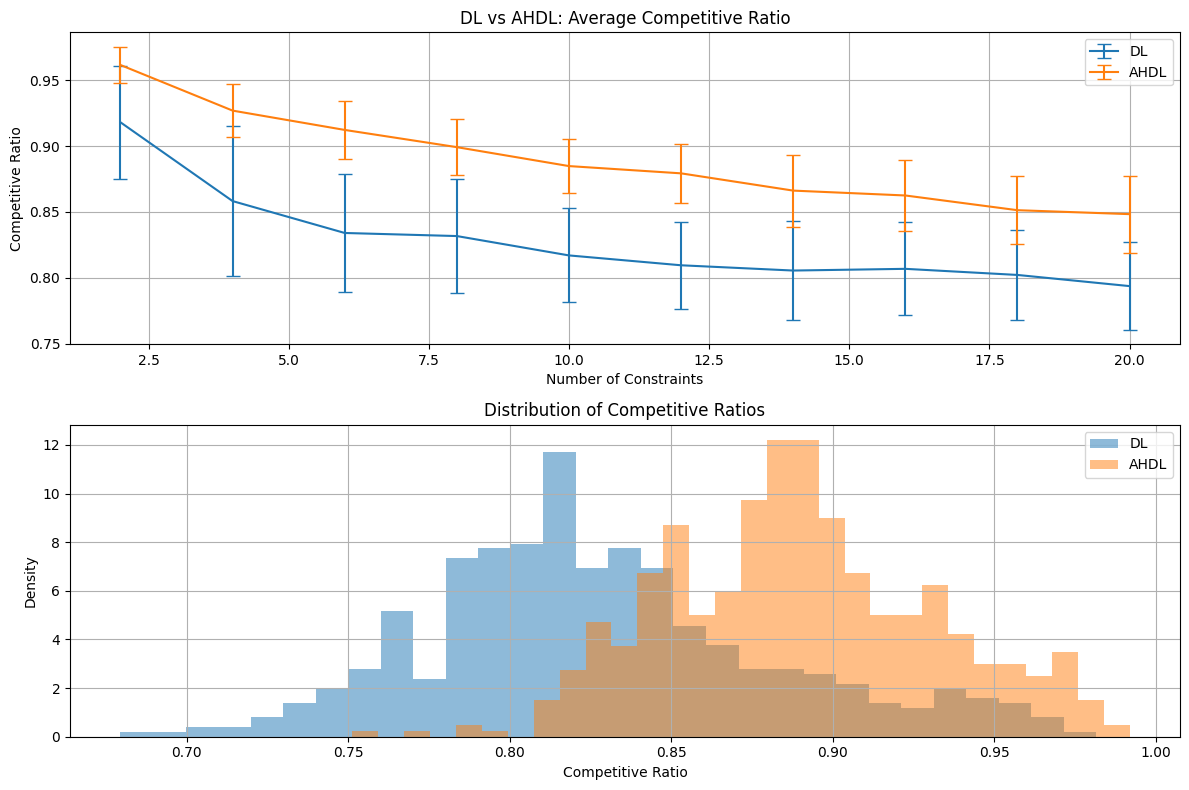


Statistical Summary:
DL - Mean: 0.8276, Std: 0.0535
AHDL - Mean: 0.8892, Std: 0.0415


In [17]:
def asymptotic_log(x, a, b):
    """Best asymptotic fit: f(x) = b + a * sqrt(log(x))"""
    return b + a * np.sqrt(np.log(x))

def asymptotic_power(x, a, b, p):
    """Power asymptotic fit: f(x) = b + a * x^p"""
    return b + a * x**p

def analyze_DL_AHDL_comparison(n_experiments=50):
    # 测试参数
    n_const_range = np.arange(2, 21, 2)  # 约束数量范围
    n_time = 1000  # 固定时间步数
    delta = 1.5    # 学习率参数
    
    # 存储结果
    results_DL = np.zeros((n_experiments, len(n_const_range)))
    results_AHDL = np.zeros((n_experiments, len(n_const_range)))
    
    # 进行实验
    for exp in range(n_experiments):
        for i, n_const in enumerate(n_const_range):
            # 生成随机测试数据
            A = np.random.rand(n_const, n_time)
            b = np.ones(n_const) * np.sqrt(n_time)
            c = np.random.rand(n_time)
            
            # 运行两种算法
            cr_DL, _, _ = DL(A, b, c, delta)
            cr_AHDL, _, _ = AHDL(A, b, c, delta)
            
            results_DL[exp, i] = cr_DL
            results_AHDL[exp, i] = cr_AHDL
            
            print(f"Experiment {exp+1}/{n_experiments}, Constraints {n_const}: DL={cr_DL:.4f}, AHDL={cr_AHDL:.4f}")
    
    # 绘制结果
    plt.figure(figsize=(12, 8))
    
    # 平均竞争比
    plt.subplot(2, 1, 1)
    plt.errorbar(n_const_range, np.mean(results_DL, axis=0), 
                yerr=np.std(results_DL, axis=0), label='DL', capsize=5)
    plt.errorbar(n_const_range, np.mean(results_AHDL, axis=0), 
                yerr=np.std(results_AHDL, axis=0), label='AHDL', capsize=5)
    plt.xlabel('Number of Constraints')
    plt.ylabel('Competitive Ratio')
    plt.title('DL vs AHDL: Average Competitive Ratio')
    plt.legend()
    plt.grid(True)
    
    # 分布对比
    plt.subplot(2, 1, 2)
    plt.hist(results_DL.flatten(), bins=30, alpha=0.5, label='DL', density=True)
    plt.hist(results_AHDL.flatten(), bins=30, alpha=0.5, label='AHDL', density=True)
    plt.xlabel('Competitive Ratio')
    plt.ylabel('Density')
    plt.title('Distribution of Competitive Ratios')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 输出统计信息
    print("\nStatistical Summary:")
    print(f"DL - Mean: {np.mean(results_DL):.4f}, Std: {np.std(results_DL):.4f}")
    print(f"AHDL - Mean: {np.mean(results_AHDL):.4f}, Std: {np.std(results_AHDL):.4f}")
    
    return results_DL, results_AHDL

# 运行分析
if __name__ == "__main__":
    results_DL, results_AHDL = analyze_DL_AHDL_comparison()